# Conditioned Generative Adversarial Network (cGAN) Model

### Trained on Kaggle

[The training code can be accessed here](https://www.kaggle.com/code/tarun42/basic-gan-1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Loading all Required Libraries
import os
import zipfile
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# Load the CSV data
data = pd.read_csv('/kaggle/input/biomaterial-attachement/BacteriaA.csv')

In [4]:
# List all image IDs from the unzipped images
image_ids = [int(file.split('.')[0]) for file in os.listdir("/kaggle/input/biomaterial-attachement/ProcessedImages")]

# Convert image IDs to a DataFrame
image_ids_df = pd.DataFrame(image_ids, columns=['FeatID'])

# Merge with the ground truth data
merged_data = pd.merge(image_ids_df, data, how='inner', on='FeatID')

In [5]:
# A custom dataloader class to keep data transfomation consistent,
# it is also necessary due to multimodal data loading is required
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """# Initializer: Accepts a dataframe with data, 
        root directory of images, and transformations to be applied."""
        self.dataframe = dataframe
        self.root_dir = root_dir
        # Resizing all images to 200x200 pixels and then applying any additional transformations.
        self.transform = transforms.Compose([transforms.Resize((200, 200)), transform])

    def __len__(self):
        """Returns the number 
        of items in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetches a single data item 
        (image and its ground truth) 
        given its index."""
        
        # Convert to list if the input is a tensor.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Getting the ground truth for the image from the dataframe.
        ground_truth = self.dataframe.iloc[idx, 1]
        ground_truth = torch.tensor(ground_truth).float()

        return image, ground_truth

In [6]:
class Generator(nn.Module):
    """
    Generator class for a Generative Adversarial Network (GAN).

    The generator's role is to generate fake data samples, trying to make them as realistic as possible.
    """
    def __init__(self, input_dim, output_dim):
        """
        Constructor for the Generator class.

        Parameters:
        - input_dim: Dimensionality of the input noise vector.
        - output_dim: Dimensionality of the output data sample.
        """
        super(Generator, self).__init__()

        # Define the neural network structure for the generator.
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # First fully connected layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(128, 256),  # Second fully connected layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(256, output_dim),  # Third fully connected layer
            nn.Tanh(),  # Tanh activation function to get output in the range [-1, 1]
        )

    def forward(self, z, ground_truth):
        """
        Forward pass for the generator.

        Parameters:
        - z: Input noise vector.
        - ground_truth: Ground truth data to be concatenated with the noise.

        Returns:
        - img: Generated fake data sample.
        """
        # Concatenate the noise vector with the ground truth data.
        x = torch.cat((z, ground_truth), dim=-1)
        
        # Pass the concatenated data through the generator model.
        img = self.model(x)
        
        return img



In [7]:
class Discriminator(nn.Module):
    """
    Discriminator class for a Generative Adversarial Network (GAN).

    The discriminator's role is to distinguish between real and fake data samples.
    """
    def __init__(self, input_dim):
        """
        Constructor for the Discriminator class.

        Parameters:
        - input_dim: Dimensionality of the input data sample.
        """
        super(Discriminator, self).__init__()

        # Define the neural network structure for the discriminator.
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # First fully connected layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(256, 128),  # Second fully connected layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(128, 1),  # Third fully connected layer
            nn.Sigmoid(),  # Sigmoid activation function to get output in the range [0, 1]
        )

    def forward(self, img, ground_truth):
        """
        Forward pass for the discriminator.

        Parameters:
        - img: Input data sample (could be real or fake).
        - ground_truth: Ground truth data to be concatenated with the input sample.

        Returns:
        - validity: Probability that the input sample is real (as opposed to fake).
        """
        # Concatenate the input data sample with the ground truth data.
        x = torch.cat((img, ground_truth), dim=-1)
        
        # Pass the concatenated data through the discriminator model.
        validity = self.model(x)
        
        return validity


In [8]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:
# Create the dataset
dataset = CustomDataset(merged_data, "/kaggle/input/biomaterial-attachement/ProcessedImages", transform=transform)

In [10]:
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
# Training configuration
num_epochs = 1000
batch_size = 32
learning_rate = 0.0001
latent_dim = 100  # Size of the latent space

# Create the Generator and Discriminator
generator = Generator(latent_dim + 1, 200 * 200 * 3)
discriminator = Discriminator(200 * 200 * 3 + 1)

# Use binary cross-entropy loss
adversarial_loss = nn.BCELoss()

# Use Adam optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Move the model and loss function to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")
generator = generator.to(device)
discriminator = discriminator.to(device)
adversarial_loss = adversarial_loss.to(device)

## Training Loop

In [19]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        labels = labels.view(labels.size(0), -1).to(device)

        # Train Generator

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_pred = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach(), labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

[Epoch 0/1000] [D loss: 0.015121004544198513] [G loss: 3.567235231399536]
[Epoch 1/1000] [D loss: 0.010321252979338169] [G loss: 4.107970714569092]
[Epoch 2/1000] [D loss: 0.03612866997718811] [G loss: 2.7991015911102295]
[Epoch 3/1000] [D loss: 0.1575065702199936] [G loss: 1.3464311361312866]
[Epoch 4/1000] [D loss: 0.032757822424173355] [G loss: 2.9410953521728516]
[Epoch 5/1000] [D loss: 0.03056226670742035] [G loss: 3.2802963256835938]
[Epoch 6/1000] [D loss: 0.17848850786685944] [G loss: 1.3199284076690674]
[Epoch 7/1000] [D loss: 0.04664040356874466] [G loss: 2.538151979446411]
[Epoch 8/1000] [D loss: 0.06069851294159889] [G loss: 2.551132917404175]
[Epoch 9/1000] [D loss: 0.05546499788761139] [G loss: 2.409743547439575]
[Epoch 10/1000] [D loss: 0.025958377867937088] [G loss: 3.158897876739502]
[Epoch 11/1000] [D loss: 0.09081409871578217] [G loss: 1.891906976699829]
[Epoch 12/1000] [D loss: 0.0246519036591053] [G loss: 3.232168674468994]
[Epoch 13/1000] [D loss: 0.01219061948359

## Generate some fake sample images

In [24]:
# Move the model to evaluation mode
generator.eval()

# Generate a batch of noise vectors
z = torch.randn(batch_size, latent_dim).to(device)

# Define the ground truth for the generated images
ground_truth = torch.tensor([0.5]*batch_size).view(-1, 1).to(device)

# Generate a batch of images
gen_imgs = generator(z, ground_truth)

# Reshape and denormalize the images
gen_imgs = gen_imgs.view(gen_imgs.size(0), 3, 200, 200)  # Reshape
gen_imgs = gen_imgs * 0.5 + 0.5  # Denormalize

# Convert tensor to numpy array
gen_imgs = gen_imgs.detach().cpu().numpy()

# Now, `gen_imgs` is a numpy array containing your generated images


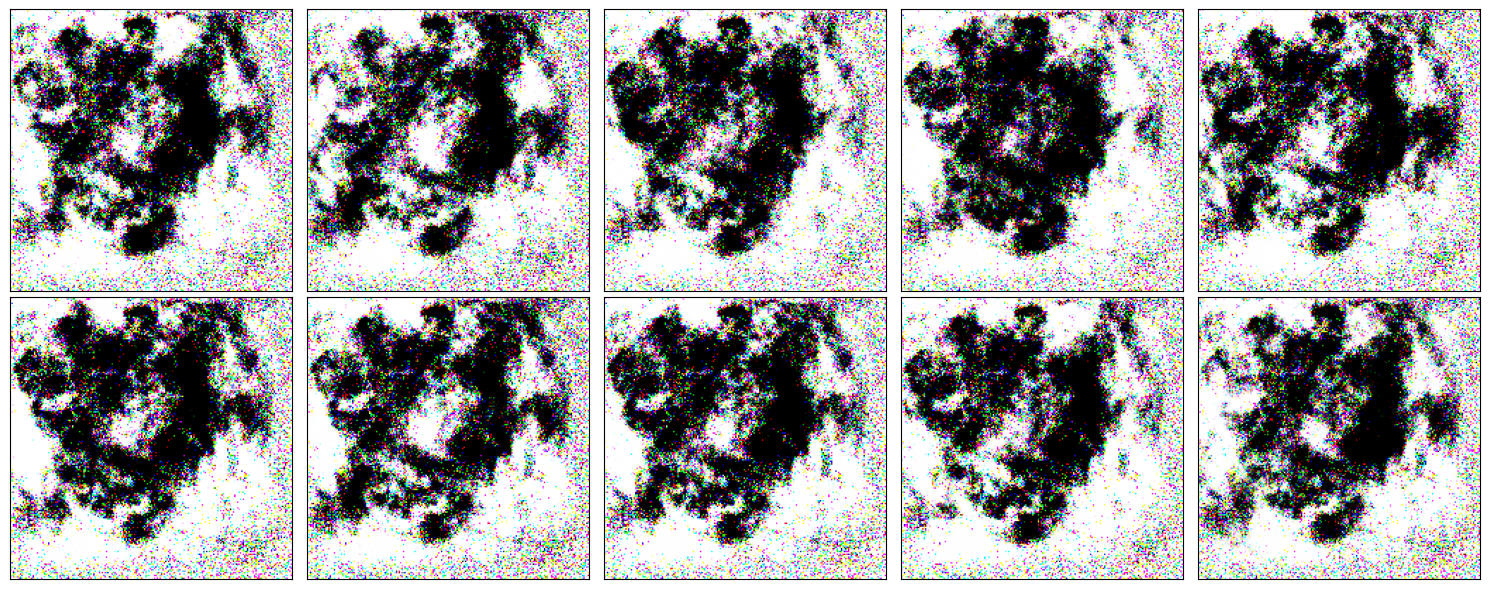

In [25]:
# Plot the generated images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    img = gen_imgs[i].transpose(1, 2, 0)  # Transpose the image dimensions
    ax.imshow(img)

plt.tight_layout()
plt.show()
